In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import datetime as dt


#import file manipulation libraries 
import os
import requests
import zipfile as zp
from io import BytesIO

import warnings
warnings.filterwarnings('ignore')
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

#Modelling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from pandas import set_option
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold



# set configurations
pd.set_option('display.max_columns', 800)
pd.set_option('display.max_rows', 400)
pd.set_option('display.min_rows', 10)
pd.set_option('display.expand_frame_repr', True)

In [2]:
#pip install --upgrade imbalanced-learn scikit-learn threadpoolctl


In [3]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [4]:
file_path = os.getcwd()+"/TRAIN_SET_2022.csv"#'/content/drive/MyDrive/final_submission/TRAIN_SET_2022.csv'

In [5]:
df=pd.read_csv(file_path)

df.head()

,RESTAURANT_SERIAL_NUMBER,RESTAURANT_PERMIT_NUMBER,RESTAURANT_NAME,RESTAURANT_LOCATION,RESTAURANT_CATEGORY,ADDRESS,CITY,STATE,ZIP,CURRENT_DEMERITS,CURRENT_GRADE,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_TIME,INSPECTION_TYPE,INSPECTION_DEMERITS,VIOLATIONS_RAW,RECORD_UPDATED,LAT_LONG_RAW,FIRST_VIOLATION,SECOND_VIOLATION,THIRD_VIOLATION,FIRST_VIOLATION_TYPE,SECOND_VIOLATION_TYPE,THIRD_VIOLATION_TYPE,NUMBER_OF_VIOLATIONS,NEXT_INSPECTION_GRADE_C_OR_BELOW
0,DA1117270,PR0004527,SANDS EXPO HALL B2 CONCESSION,SANDS EXPO & CONVENTION CENTER,Snack Bar,201 E Sands Ave,Las Vegas,Nevada,89169-2617,0.0,A,25.0,27.95998269,13.004886,11/5/2013 16:15,Routine Inspection,11,"2,042,153,022,955",1/6/2015 16:34,"(36.1221442, 115.1652749)",204.0,215.0,302.0,Critical,Major,Imminent Health Hazard,4,0
1,DA1014948,PR0024221,THAI NOODLES CAFE - RESTAURANT,THAI NOODLES CAFE,Restaurant,6710 W CHEYENNE Ave,Las Vegas,Nevada,89108-4588,3.0,A,7.0,27.71936533,3.922086,9/21/2012 13:00,Routine Inspection,9,"214,216,229,230,233",2/21/2013 22:26,"(36.218691, 115.242913)",214.0,216.0,229.0,Major,Major,Non-Major,5,0
2,DA0861994,PR0019017,SANTA FE SPORTS BOOK GRILL,Santa Fe Station Hotel & Casino,Restaurant,4949 N Rancho Dr,Las Vegas,Nevada,89130-3505,8.0,A,23.0,26.44263674,10.312777,9/16/2011 11:50,Routine Inspection,9,"202,215,233",4/6/2015 9:00,"(36.2498922, 115.2441383)",202.0,215.0,233.0,Critical,Major,Non-Major,3,1
3,DA0896719,PR0001343,"Bracken, Walter Elem School Kit","Bracken, Walter Elem School",Elementary School Kitchen,1200 N 27Th St,Las Vegas,Nevada,89101-1517,0.0,A,14.0,33.98829267,4.163975,11/22/2011 11:40,Routine Inspection,5,"214,230,233",2/21/2013 22:26,"(36.183669, 115.112355)",214.0,230.0,233.0,Major,Non-Major,Non-Major,3,0
4,DA1031041,PR0006084,HARD ROCK JOINT EAST SVC BAR FL 1,HARD ROCK HOTEL & CASINO,Bar / Tavern,4455 S Paradise Rd,Las Vegas,Nevada,89169-6574,0.0,A,10.0,21.98028217,13.462786,11/9/2012 20:30,Routine Inspection,5,"214,230,233",2/21/2013 22:26,"(36.1100828, 115.1538714)",214.0,230.0,233.0,Major,Non-Major,Non-Major,NaN,0


In [6]:

def to_floats(column):
    '''
    change numbers that are strings to floats
    '''
    try:
        return float(column)
    except:
        #print(column)
        return np.NaN
    
def print_time(row):
    '''
    put time in datetime format    
    '''
    try:
        return pd.to_datetime(row)
    except:
        #print(row)
        return np.NaN

In [7]:

# function replace_violation_type
# Replaces values that are not in the main violation type classes Major, Non-Major, Critical
# Whiles looking at other violations with violation type that matches
def replace_violation_type(row, violation_col):
    '''
    Replacing values that are not in the main violation type classes [Major, Non-Major, Critical]
    '''
    violation_type = violation_col + '_TYPE'
    main_violations = ['Major', 'Non-Major', 'Critical']

    if row[violation_type] not in main_violations:
        violation_val = row[violation_col]
        grouped_df = df[df[violation_col]==violation_val].groupby(by=violation_type, as_index=False).count().sort_values(by=violation_col,ascending=False)
        violation_score = grouped_df.to_dict(orient='records')
        for category in violation_score:
            if category[violation_type] in main_violations:
                row[violation_type] = category[violation_type]
            elif category[violation_type] not in main_violations:
                row[violation_type] = 'Critical'
#                 print(category[violation_type], row[violation_type])
#                 print('--------------------------------------')
#                 print(category)
#                 break
    return row
 

In [8]:
 
# function create_current_grade
# Creates current grades base their demerits

def create_current_grade(demerit):
    
    if demerit>=0 and demerit<=10:
        return 'A'
    elif demerit <=20:
        return 'B'
    elif demerit <=40:
        return 'C'
    elif demerit > 40:
        return 'D'
    else:
        #print(demerit)
        return np.NaN


In [9]:


df['NEXT_INSPECTION_GRADE_C_OR_BELOW'].value_counts()


0       12947
1        2680
-3          1
Goat        1
7           1
9           1
4           1
3           1
Name: NEXT_INSPECTION_GRADE_C_OR_BELOW, dtype: int64

In [10]:

#combine ['7','9','3','4'] as '1s'
df['NEXT_INSPECTION_GRADE_C_OR_BELOW']=df['NEXT_INSPECTION_GRADE_C_OR_BELOW'].replace(['7','9','3','4''-1'],'1')
df=df[df['NEXT_INSPECTION_GRADE_C_OR_BELOW'].isin(['0','1'])]

In [11]:

df['NEXT_INSPECTION_GRADE_C_OR_BELOW'].value_counts()


0    12947
1     2683
Name: NEXT_INSPECTION_GRADE_C_OR_BELOW, dtype: int64

In [12]:


df.columns


Index(['RESTAURANT_SERIAL_NUMBER', 'RESTAURANT_PERMIT_NUMBER',
       'RESTAURANT_NAME', 'RESTAURANT_LOCATION', 'RESTAURANT_CATEGORY',
       'ADDRESS', 'CITY', 'STATE', 'ZIP', 'CURRENT_DEMERITS', 'CURRENT_GRADE',
       'EMPLOYEE_COUNT', 'MEDIAN_EMPLOYEE_AGE', 'MEDIAN_EMPLOYEE_TENURE',
       'INSPECTION_TIME', 'INSPECTION_TYPE', 'INSPECTION_DEMERITS',
       'VIOLATIONS_RAW', 'RECORD_UPDATED', 'LAT_LONG_RAW', 'FIRST_VIOLATION',
       'SECOND_VIOLATION', 'THIRD_VIOLATION', 'FIRST_VIOLATION_TYPE',
       'SECOND_VIOLATION_TYPE', 'THIRD_VIOLATION_TYPE', 'NUMBER_OF_VIOLATIONS',
       'NEXT_INSPECTION_GRADE_C_OR_BELOW'],
      dtype='object')

In [13]:

df.dropna(subset=["INSPECTION_TIME", 'RESTAURANT_CATEGORY', "RECORD_UPDATED", "LAT_LONG_RAW"], inplace=True)

In [14]:

def split_lat_long(df,lalong,new_col):
    df[[new_col[0],new_col[1]]] = df[lalong].str.strip('()').str.split(', ', expand=True) \
                                  .rename(columns={0:new_col[0], 1:new_col[1]})
    return df


In [15]:
    
# Split LAT_LONG_RAW (lat,lon) feature into two separate columns as Longitude and Latitude
# Drop LAT_LONG_RAW
# Change the format from string to floats using tofloats

#df[['LATITUDE','LONGITUDE']]=df['LAT_LONG_RAW'].str.strip('()').str.split(', ', expand=True) \
 #                                 .rename(columns={0:'LATITUDE', 1:'LONGITUDE'}) 
df = split_lat_long(df,'LAT_LONG_RAW',['LATITUDE','LONGITUDE'])   
df.drop('LAT_LONG_RAW',axis=1, inplace=True)

df['LATITUDE'] = df['LATITUDE'].apply(to_floats)
df['LONGITUDE'] = df['LONGITUDE'].apply(to_floats)

In [16]:

df.isnull().sum()


RESTAURANT_SERIAL_NUMBER              0
RESTAURANT_PERMIT_NUMBER              0
RESTAURANT_NAME                      62
RESTAURANT_LOCATION                 195
RESTAURANT_CATEGORY                   0
ADDRESS                              68
CITY                                230
STATE                               201
ZIP                                  59
CURRENT_DEMERITS                    208
CURRENT_GRADE                       295
EMPLOYEE_COUNT                       92
MEDIAN_EMPLOYEE_AGE                  34
MEDIAN_EMPLOYEE_TENURE              288
INSPECTION_TIME                       0
INSPECTION_TYPE                     212
INSPECTION_DEMERITS                 248
VIOLATIONS_RAW                      163
RECORD_UPDATED                        0
FIRST_VIOLATION                     206
SECOND_VIOLATION                     80
THIRD_VIOLATION                      58
FIRST_VIOLATION_TYPE                142
SECOND_VIOLATION_TYPE               261
THIRD_VIOLATION_TYPE                169


In [17]:

# changing date formats. from m/dd/yyyy hr:mm:ss to m-dd-yyyy
# create new colums with year, month, day and hour

df['INSPECTION_TIME'] = df['INSPECTION_TIME'].apply(print_time)
df['RECORD_UPDATED'] = df['RECORD_UPDATED'].apply(print_time)
df['INSPECTION_TIME_HOUR'] = df['INSPECTION_TIME'].apply(print_time).dt.hour
df['INSPECTION_TIME_DAY'] = df['INSPECTION_TIME'].apply(print_time).dt.day
df['INSPECTION_TIME_MONTH'] = df['INSPECTION_TIME'].apply(print_time).dt.month
df['INSPECTION_TIME_YEAR'] = df['INSPECTION_TIME'].apply(print_time).dt.year
df['RECORD_UPDATED_HOUR'] = df['RECORD_UPDATED'].apply(print_time).dt.hour
df['RECORD_UPDATED_DAY'] = df['RECORD_UPDATED'].apply(print_time).dt.day
df['RECORD_UPDATED_MONTH'] = df['RECORD_UPDATED'].apply(print_time).dt.month
df['RECORD_UPDATED_YEAR'] = df['RECORD_UPDATED'].apply(print_time).dt.year    


In [18]:
# Truncate zip codes. for consistency I may nopt use it after all
# some are 36423-03467 others are 35472.
# Putting all in 35472.
df['ZIP'] =df['ZIP'].apply(lambda x: str(x)[:5] if len(str(x)) >5 else x)


In [19]:
# Change FROM STRING TO FLOAT
# NUMBER_OF_VIOLATIONS
# MEDIAN_EMPLOYEE_AGE
# CURRENT_DEMERITS
# EMPLOYEE_COUNT
# MEDIAN_EMPLOYEE_TENURE
df['NUMBER_OF_VIOLATIONS']=df['NUMBER_OF_VIOLATIONS'].apply(to_floats)
df['MEDIAN_EMPLOYEE_AGE'] = df['MEDIAN_EMPLOYEE_AGE'].apply(to_floats)
df['EMPLOYEE_COUNT'] = df['EMPLOYEE_COUNT'].apply(to_floats)
df['CURRENT_DEMERITS'] = df['CURRENT_DEMERITS'].apply(to_floats)
df['INSPECTION_DEMERITS'] = df['INSPECTION_DEMERITS'].apply(to_floats)
df['MEDIAN_EMPLOYEE_TENURE'] = df['MEDIAN_EMPLOYEE_TENURE'].apply(to_floats)


In [20]:
# Exploratory Data Analysis
# In this section, I will explore each variable,treat missing values if any. For the categorical variables, I will use countplots to visualize thier distribution. For the continous variables, I will use histograms and boxplots.

def extract_featureTypes(df):
    
    
    ''' Extracts categorical and numerical features from a dataframe
    
            Parameters:
        
                df(DataFrame): Python dataframe
        
            Returns:
        
                object_cols: List of categorical feature names
        
                numerical_cols: List of numerical feature names
    '''
    #categorical columns
    objs = (df.dtypes == 'object') 
    bools= (df.dtypes == 'bool')
    
    objs_cols = list(objs[objs].index)
    bools_cols = list(bools[bools].index)
    
    object_cols = objs_cols + bools_cols
    
    #numerical columns
    ints = (df.dtypes == 'int64') 
    floats=(df.dtypes == 'float64')
    
    ints_cols=list(ints[ints].index)
    floats_cols=list(floats[floats].index)
    
    numeric_cols = ints_cols + floats_cols
    
    return object_cols,numeric_cols


In [21]:
df_new = df.copy()
drop_col = ['RESTAURANT_SERIAL_NUMBER','RESTAURANT_PERMIT_NUMBER','RESTAURANT_LOCATION', \
           'ADDRESS', 'CITY', 'STATE', 'ZIP','INSPECTION_TIME','RECORD_UPDATED','VIOLATIONS_RAW']
df_new.drop(columns=drop_col,axis=1,inplace=True)

categorical_cols,_=extract_featureTypes(df_new)

print(categorical_cols)
['RESTAURANT_NAME', 'RESTAURANT_CATEGORY', 'CURRENT_GRADE', 'INSPECTION_TYPE', 'FIRST_VIOLATION_TYPE', 'SECOND_VIOLATION_TYPE', 'THIRD_VIOLATION_TYPE', 'NEXT_INSPECTION_GRADE_C_OR_BELOW']


['RESTAURANT_NAME', 'RESTAURANT_CATEGORY', 'CURRENT_GRADE', 'INSPECTION_TYPE', 'FIRST_VIOLATION_TYPE', 'SECOND_VIOLATION_TYPE', 'THIRD_VIOLATION_TYPE', 'NEXT_INSPECTION_GRADE_C_OR_BELOW']


['RESTAURANT_NAME',
 'RESTAURANT_CATEGORY',
 'CURRENT_GRADE',
 'INSPECTION_TYPE',
 'FIRST_VIOLATION_TYPE',
 'SECOND_VIOLATION_TYPE',
 'THIRD_VIOLATION_TYPE',
 'NEXT_INSPECTION_GRADE_C_OR_BELOW']

In [22]:
# summary of categorical variables 
df_new[categorical_cols].describe().transpose().sort_values(by=['unique'])

,count,unique,top,freq
NEXT_INSPECTION_GRADE_C_OR_BELOW,15187,2,0,12585
SECOND_VIOLATION_TYPE,14926,10,Major,7658
INSPECTION_TYPE,14975,12,Routine Inspection,14127
THIRD_VIOLATION_TYPE,15018,12,Non-Major,7061
FIRST_VIOLATION_TYPE,15045,14,Critical,6948
CURRENT_GRADE,14892,20,A,14341
RESTAURANT_CATEGORY,15187,34,Restaurant,9093
RESTAURANT_NAME,15125,8179,Robertos Taco Shop,96


In [23]:


# Helper function for plotting categorical variables
def plot_categorical(df,feature,bycat):
    
    ''' Plot of Categorical varibles and replaces missing values with mode.
    
            Parameters:
        
                df(DataFrame): Python dataframe of custormers
            
                feature(string): Name of categorical feature
            
                bycat(boo): Boolean to indicate whether the plot should be by isChurn category
              
    '''
    
    if bycat is True:
        
        print(df[feature].value_counts(normalize=True),'\n')
        
        plt.figure(figsize=(10,7))
        
        sns.countplot(x=feature,hue="NEXT_INSPECTION_GRADE_C_OR_BELOW", data=df)
        
        plt.xticks(rotation=90)
        
        plt.ylabel('Number of Categories')
    
    else:
        print(df[feature].value_counts(normalize=True),'\n')
        
        plt.figure(figsize=(10,7))
        
        sns.countplot(x=feature, data=df)
        
        plt.xticks(rotation=90)
        
        plt.ylabel('RESTAURANT_CATEGORY') 

0    0.828669
1    0.171331
Name: NEXT_INSPECTION_GRADE_C_OR_BELOW, dtype: float64 



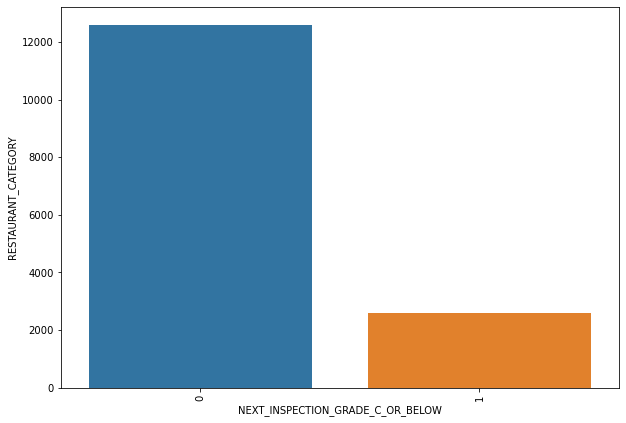

In [24]:

#NEXT_INSPECTION_GRADE_C_OR_BELOW

plot_categorical(df_new,'NEXT_INSPECTION_GRADE_C_OR_BELOW',bycat=False)



Critical                             0.461815
Major                                0.433300
Non-Major                            0.102559
Supercalifragilisticexpialidocius    0.000731
Kritical                             0.000665
Not Critical Enough                  0.000266
Imminent Health Hazard               0.000199
Extra Crispy                         0.000066
Major-ish                            0.000066
To Infinity and Beyond               0.000066
Not Sure                             0.000066
Radical                              0.000066
Excellent                            0.000066
Bullwinkle                           0.000066
Name: FIRST_VIOLATION_TYPE, dtype: float64 



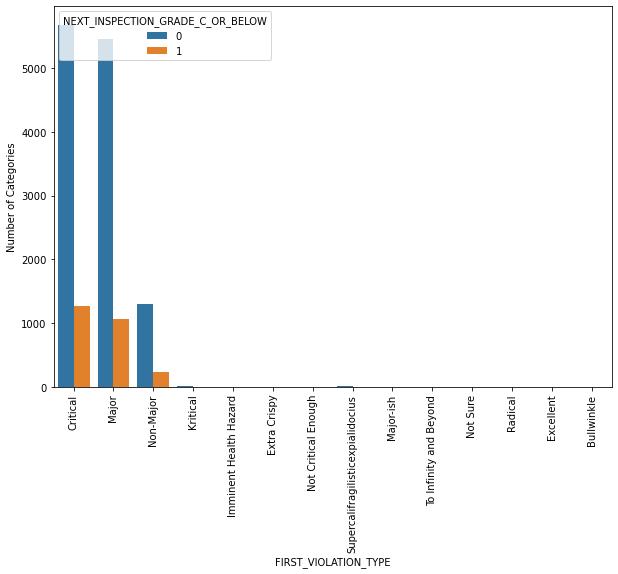

In [25]:

plot_categorical(df_new,'FIRST_VIOLATION_TYPE',bycat=True)



In [26]:

_,numerical_cols=extract_featureTypes(df_new)
print(numerical_cols)


['CURRENT_DEMERITS', 'EMPLOYEE_COUNT', 'MEDIAN_EMPLOYEE_AGE', 'MEDIAN_EMPLOYEE_TENURE', 'INSPECTION_DEMERITS', 'FIRST_VIOLATION', 'SECOND_VIOLATION', 'THIRD_VIOLATION', 'NUMBER_OF_VIOLATIONS', 'LATITUDE', 'LONGITUDE', 'INSPECTION_TIME_HOUR', 'INSPECTION_TIME_DAY', 'INSPECTION_TIME_MONTH', 'INSPECTION_TIME_YEAR', 'RECORD_UPDATED_HOUR', 'RECORD_UPDATED_DAY', 'RECORD_UPDATED_MONTH', 'RECORD_UPDATED_YEAR']


In [27]:

def plot_numerical(df,feature):
    
    ''' Plot of numerical variables 
    
            Parameters:
        
                df(DataFrame): Python dataframe of custormers
            
                feature(string): Name of numerical feature
             
    '''
    print(df[feature].describe())
    fig = plt.figure(figsize=(12,6))
    #Histogram
    plt.subplot(121)
    sns.histplot(data=df, x=feature, kde=True, bins=20,stat="density")
    #Boxplot
    plt.subplot(122)
    sns.boxplot(y=feature,data=df,x='NEXT_INSPECTION_GRADE_C_OR_BELOW') 
    plt.show()
    
    
    

count    14979.000000
mean         5.238704
std         14.088114
min          0.000000
25%          0.000000
50%          5.000000
75%          8.000000
max       1214.000000
Name: CURRENT_DEMERITS, dtype: float64


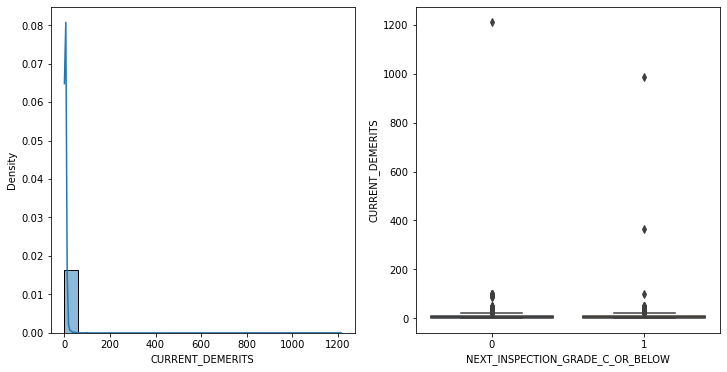

In [28]:



plot_numerical(df_new,'CURRENT_DEMERITS')



count     15095.000000
mean         22.515071
std         907.059221
min          -7.000000
25%           8.000000
50%          14.000000
75%          21.000000
max      111447.000000
Name: EMPLOYEE_COUNT, dtype: float64


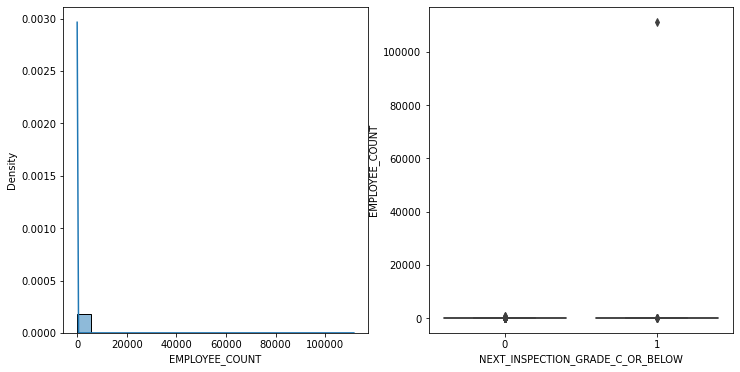

In [29]:

plot_numerical(df_new,'EMPLOYEE_COUNT')


count    1.514900e+04
mean     2.722094e+12
std      3.350388e+14
min     -3.146213e+00
25%      2.461561e+01
50%      2.798403e+01
75%      3.140981e+01
max      4.123700e+16
Name: MEDIAN_EMPLOYEE_AGE, dtype: float64


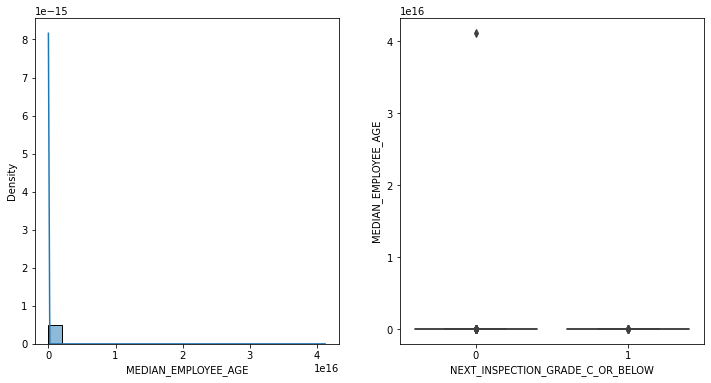

In [30]:


plot_numerical(df_new,'MEDIAN_EMPLOYEE_AGE')



count    14899.000000
mean         4.030920
std          2.023376
min          0.227197
25%          2.550675
50%          3.697777
75%          5.143092
max         24.399347
Name: MEDIAN_EMPLOYEE_TENURE, dtype: float64


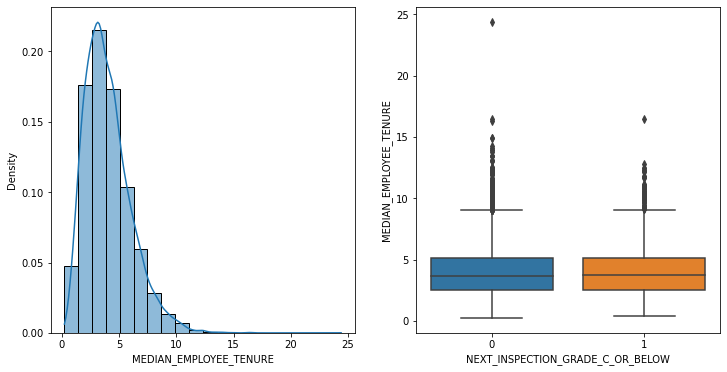

In [31]:

plot_numerical(df_new,'MEDIAN_EMPLOYEE_TENURE')



count     14933.00000
mean         30.03509
std        1994.05333
min         -10.00000
25%           8.00000
50%          10.00000
75%          19.00000
max      243678.00000
Name: INSPECTION_DEMERITS, dtype: float64


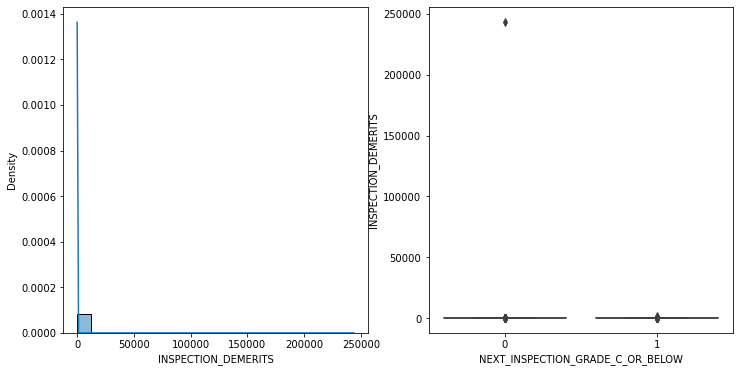

In [32]:

plot_numerical(df_new,'INSPECTION_DEMERITS')



count    15021.000000
mean         5.736103
std          3.020237
min          3.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         42.000000
Name: NUMBER_OF_VIOLATIONS, dtype: float64


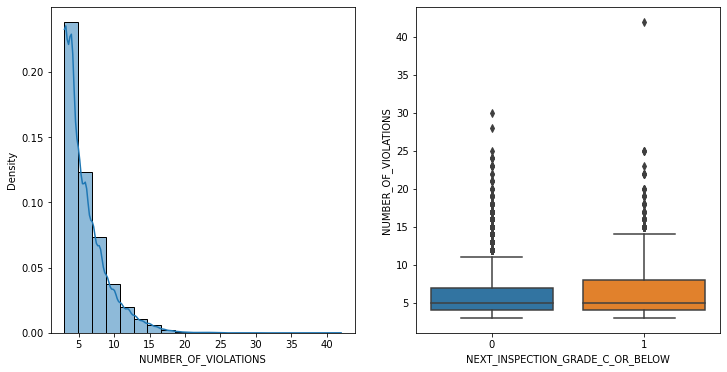

In [33]:

plot_numerical(df_new,'NUMBER_OF_VIOLATIONS')


In [34]:

def remove_outliers(data,column):
    
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3-Q1
    upper = (Q3+1.5*IQR)
    lower = (Q3-1.5*IQR)
    data = data[~(data[column]>upper)] ### only using upper because from the boxplots, all the outliers are upper
    data = data[~(data[column]<lower)]
    
    return data


In [35]:

df[numerical_cols].describe()


,CURRENT_DEMERITS,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_DEMERITS,FIRST_VIOLATION,SECOND_VIOLATION,THIRD_VIOLATION,NUMBER_OF_VIOLATIONS,LATITUDE,LONGITUDE,INSPECTION_TIME_HOUR,INSPECTION_TIME_DAY,INSPECTION_TIME_MONTH,INSPECTION_TIME_YEAR,RECORD_UPDATED_HOUR,RECORD_UPDATED_DAY,RECORD_UPDATED_MONTH,RECORD_UPDATED_YEAR
count,14979.000000,15095.000000,1.514900e+04,14899.000000,14933.00000,1.498100e+04,15107.000000,15129.000000,15021.000000,15187.000000,15187.000000,15184.000000,15184.000000,15184.000000,15184.000000,15186.000000,15186.000000,15186.000000,15186.000000
mean,5.238704,22.515071,2.722094e+12,4.030920,30.03509,7.443089e+02,171.869663,179.236698,5.736103,36.113371,113.053302,12.714634,15.713053,6.243085,2012.355308,18.589885,19.011063,3.360332,2013.685171
std,14.088114,907.059221,3.350388e+14,2.023376,1994.05333,7.087720e+04,80.086674,77.399073,3.020237,0.766787,21.702503,2.819734,8.632137,3.206640,2.450970,4.963866,5.736034,2.676404,1.523427
min,0.000000,-7.000000,-3.146213e+00,0.227197,-10.00000,1.000000e+00,2.000000,4.000000,3.000000,0.000000,-115.307572,0.000000,1.000000,1.000000,1900.000000,0.000000,1.000000,1.000000,1900.000000
25%,0.000000,8.000000,2.461561e+01,2.550675,8.00000,2.020000e+02,204.000000,209.000000,4.000000,36.098731,115.116214,11.000000,8.000000,3.000000,2011.000000,14.000000,21.000000,2.000000,2013.000000
50%,5.000000,14.000000,2.798403e+01,3.697777,10.00000,2.060000e+02,211.000000,215.000000,5.000000,36.120601,115.168525,13.000000,16.000000,6.000000,2012.000000,22.000000,21.000000,2.000000,2013.000000
75%,8.000000,21.000000,3.140981e+01,5.143092,19.00000,2.110000e+02,215.000000,227.000000,7.000000,36.161135,115.201785,15.000000,23.000000,9.000000,2014.000000,22.000000,21.000000,3.000000,2014.000000
max,1214.000000,111447.000000,4.123700e+16,24.399347,243678.00000,8.675309e+06,302.000000,310.000000,42.000000,52.157900,115.679632,23.000000,31.000000,12.000000,2036.000000,23.000000,31.000000,12.000000,2021.000000


In [36]:

#I assume those negative numbers are entry errors therefore I take the absolute of all of them.
df[['CURRENT_DEMERITS','EMPLOYEE_COUNT','MEDIAN_EMPLOYEE_AGE','INSPECTION_DEMERITS']] = abs(df[['CURRENT_DEMERITS','EMPLOYEE_COUNT','MEDIAN_EMPLOYEE_AGE','INSPECTION_DEMERITS']])

df[numerical_cols].describe()


,CURRENT_DEMERITS,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_DEMERITS,FIRST_VIOLATION,SECOND_VIOLATION,THIRD_VIOLATION,NUMBER_OF_VIOLATIONS,LATITUDE,LONGITUDE,INSPECTION_TIME_HOUR,INSPECTION_TIME_DAY,INSPECTION_TIME_MONTH,INSPECTION_TIME_YEAR,RECORD_UPDATED_HOUR,RECORD_UPDATED_DAY,RECORD_UPDATED_MONTH,RECORD_UPDATED_YEAR
count,14979.000000,15095.000000,1.514900e+04,14899.000000,14933.000000,1.498100e+04,15107.000000,15129.000000,15021.000000,15187.000000,15187.000000,15184.000000,15184.000000,15184.000000,15184.000000,15186.000000,15186.000000,15186.000000,15186.000000
mean,5.238704,22.515999,2.722094e+12,4.030920,30.036429,7.443089e+02,171.869663,179.236698,5.736103,36.113371,113.053302,12.714634,15.713053,6.243085,2012.355308,18.589885,19.011063,3.360332,2013.685171
std,14.088114,907.059198,3.350388e+14,2.023376,1994.053309,7.087720e+04,80.086674,77.399073,3.020237,0.766787,21.702503,2.819734,8.632137,3.206640,2.450970,4.963866,5.736034,2.676404,1.523427
min,0.000000,3.000000,3.146213e+00,0.227197,0.000000,1.000000e+00,2.000000,4.000000,3.000000,0.000000,-115.307572,0.000000,1.000000,1.000000,1900.000000,0.000000,1.000000,1.000000,1900.000000
25%,0.000000,8.000000,2.461561e+01,2.550675,8.000000,2.020000e+02,204.000000,209.000000,4.000000,36.098731,115.116214,11.000000,8.000000,3.000000,2011.000000,14.000000,21.000000,2.000000,2013.000000
50%,5.000000,14.000000,2.798403e+01,3.697777,10.000000,2.060000e+02,211.000000,215.000000,5.000000,36.120601,115.168525,13.000000,16.000000,6.000000,2012.000000,22.000000,21.000000,2.000000,2013.000000
75%,8.000000,21.000000,3.140981e+01,5.143092,19.000000,2.110000e+02,215.000000,227.000000,7.000000,36.161135,115.201785,15.000000,23.000000,9.000000,2014.000000,22.000000,21.000000,3.000000,2014.000000
max,1214.000000,111447.000000,4.123700e+16,24.399347,243678.000000,8.675309e+06,302.000000,310.000000,42.000000,52.157900,115.679632,23.000000,31.000000,12.000000,2036.000000,23.000000,31.000000,12.000000,2021.000000


In [37]:

#Remove the outliers in these columns using the remove_outliers function
df_new = remove_outliers(df_new,'MEDIAN_EMPLOYEE_AGE')
df_new = remove_outliers(df_new,'EMPLOYEE_COUNT')
df_new = remove_outliers(df_new,'MEDIAN_EMPLOYEE_TENURE')
df_new = remove_outliers(df_new,'CURRENT_DEMERITS')
df_new = remove_outliers(df_new,'INSPECTION_DEMERITS')
df_new[numerical_cols].describe()


,CURRENT_DEMERITS,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_DEMERITS,FIRST_VIOLATION,SECOND_VIOLATION,THIRD_VIOLATION,NUMBER_OF_VIOLATIONS,LATITUDE,LONGITUDE,INSPECTION_TIME_HOUR,INSPECTION_TIME_DAY,INSPECTION_TIME_MONTH,INSPECTION_TIME_YEAR,RECORD_UPDATED_HOUR,RECORD_UPDATED_DAY,RECORD_UPDATED_MONTH,RECORD_UPDATED_YEAR
count,12251.000000,12338.000000,12380.000000,12166.000000,12201.000000,1.225600e+04,12348.000000,12365.000000,12284.000000,12413.000000,12413.000000,12412.000000,12412.000000,12412.000000,12412.000000,12412.000000,12412.000000,12412.000000,12412.000000
mean,4.708804,14.833279,28.804987,4.005198,12.687075,8.720068e+02,170.962990,178.604852,5.447167,36.110100,113.242074,12.716081,15.681840,6.224863,2012.318724,18.653319,19.071705,3.334515,2013.677651
std,3.709156,8.729422,4.216381,1.726660,6.956641,7.836147e+04,80.823902,78.021954,2.529203,0.774795,20.692845,2.832206,8.663545,3.209338,2.523999,4.948345,5.675839,2.654054,1.203468
min,0.000000,3.000000,21.221836,1.251557,3.000000,1.000000e+00,2.000000,4.000000,3.000000,0.000000,-115.307572,0.000000,1.000000,1.000000,1900.000000,0.000000,1.000000,1.000000,2011.000000
25%,0.000000,8.000000,25.556075,2.650920,7.000000,2.020000e+02,204.000000,209.000000,4.000000,36.098731,115.116328,11.000000,8.000000,3.000000,2011.000000,14.000000,21.000000,2.000000,2013.000000
50%,5.000000,14.000000,28.497874,3.743596,10.000000,2.060000e+02,211.000000,215.000000,5.000000,36.120601,115.169098,13.000000,16.000000,6.000000,2012.000000,22.000000,21.000000,2.000000,2013.000000
75%,8.000000,21.000000,31.734504,5.083881,18.000000,2.110000e+02,215.000000,227.000000,7.000000,36.161671,115.200867,15.000000,23.000000,9.000000,2014.000000,22.000000,21.000000,3.000000,2014.000000
max,20.000000,40.000000,41.480601,9.027850,35.000000,8.675309e+06,302.000000,310.000000,42.000000,52.157900,115.679632,23.000000,31.000000,12.000000,2036.000000,23.000000,31.000000,12.000000,2017.000000


count    12380.000000
mean        28.804987
std          4.216381
min         21.221836
25%         25.556075
50%         28.497874
75%         31.734504
max         41.480601
Name: MEDIAN_EMPLOYEE_AGE, dtype: float64


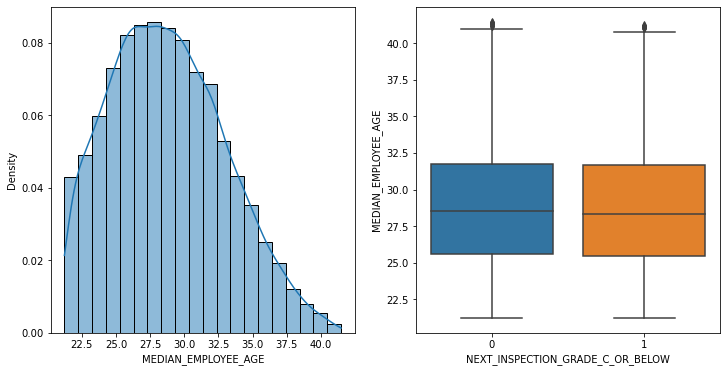

count    12338.000000
mean        14.833279
std          8.729422
min          3.000000
25%          8.000000
50%         14.000000
75%         21.000000
max         40.000000
Name: EMPLOYEE_COUNT, dtype: float64


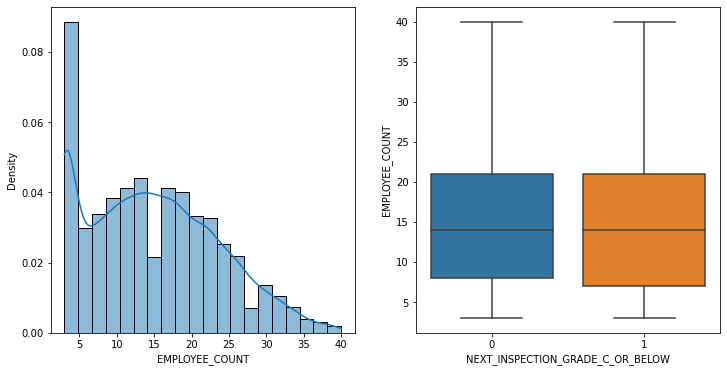

count    12166.000000
mean         4.005198
std          1.726660
min          1.251557
25%          2.650920
50%          3.743596
75%          5.083881
max          9.027850
Name: MEDIAN_EMPLOYEE_TENURE, dtype: float64


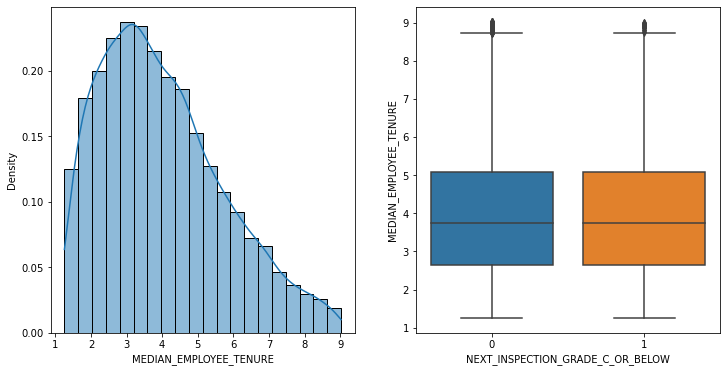

count    12251.000000
mean         4.708804
std          3.709156
min          0.000000
25%          0.000000
50%          5.000000
75%          8.000000
max         20.000000
Name: CURRENT_DEMERITS, dtype: float64


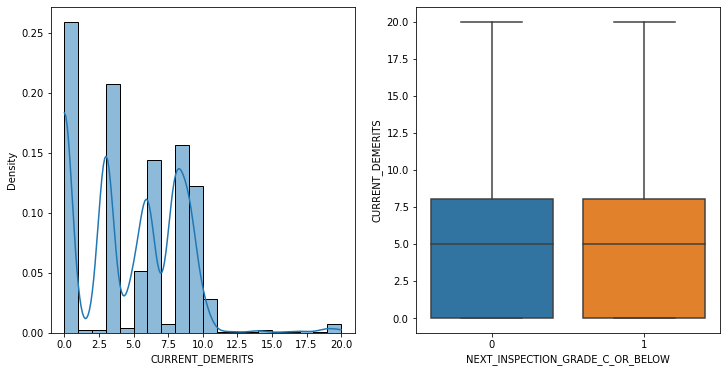

count    12201.000000
mean        12.687075
std          6.956641
min          3.000000
25%          7.000000
50%         10.000000
75%         18.000000
max         35.000000
Name: INSPECTION_DEMERITS, dtype: float64


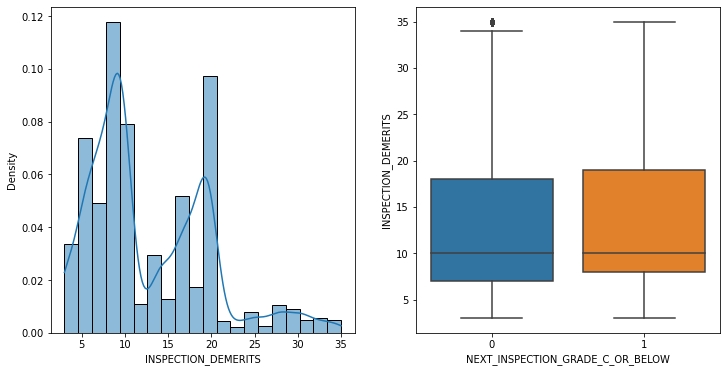

In [38]:

#visualize their boxplots again

plot_numerical(df_new,'MEDIAN_EMPLOYEE_AGE')
plot_numerical(df_new,'EMPLOYEE_COUNT')
plot_numerical(df_new,'MEDIAN_EMPLOYEE_TENURE')
plot_numerical(df_new,'CURRENT_DEMERITS')
plot_numerical(df_new,'INSPECTION_DEMERITS')

 

In [39]:

df_new.shape


(12413, 27)

<AxesSubplot:xlabel='CURRENT_DEMERITS', ylabel='CURRENT_GRADE'>

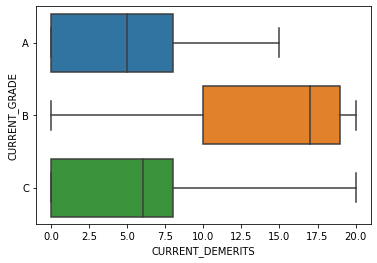

In [40]:

#CURRENT_DEMERITS and CURRENT_GRADE
sns.boxplot(y='CURRENT_GRADE', x='CURRENT_DEMERITS',data=df_new[df_new['CURRENT_GRADE'].isin(['A','B','C'])] )

 

In [41]:

#_violation type and current grade creation
df_new=df_new.apply(lambda row: replace_violation_type(row, 'FIRST_VIOLATION'), axis=1)
df_new=df_new.apply(lambda row: replace_violation_type(row, 'SECOND_VIOLATION'), axis=1)
df_new=df_new.apply(lambda row: replace_violation_type(row, 'THIRD_VIOLATION'), axis=1)

## Current grade creation
df_new['CURRENT_GRADE']=df_new['CURRENT_DEMERITS'].apply(create_current_grade)

In [42]:

ind=df_new[~df_new['INSPECTION_TYPE'].isin(['Routine Inspection','Re-inspection'])].index
df_new.loc[ind,'INSPECTION_TYPE']=np.NaN


In [43]:

# Preprocessing
# Train Test Split
# Before creating models, I will split the data into train test sets, setting the test-size to 25%. Due to the highly imbalance nature of the data, I will use stratified split technique. The function split_data is used here.

def split_data(X,y,test_size):
    
    ''' Splits data into train and tests sets
    
            Returns:
            
                X_train (DataFrame): A python dataframe of train fetaures
                
                X_test (DataFrame): A python dataframe of test features
                
                y_train (series): A python series for dependent variable]
                
                y_test (series): A python series for dependent variable 
                
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25,shuffle=True,random_state=42)
    
    return X_train, X_test, y_train, y_test
 



In [44]:

# specify predictors and dependent variable before split
train_data = df_new.copy()
train_data['THIRD_VIOLATION_TYPE'].value_counts()



Non-Major    5986
Major        5881
Critical      545
Name: THIRD_VIOLATION_TYPE, dtype: int64

In [45]:

train_data['FIRST_VIOLATION_TYPE']=train_data['FIRST_VIOLATION_TYPE'].replace('Not Critical Enough','Major')

In [46]:

X=train_data.drop(columns=['NEXT_INSPECTION_GRADE_C_OR_BELOW'],axis=1)

y=train_data['NEXT_INSPECTION_GRADE_C_OR_BELOW']

X_train, X_val, y_train, y_val = split_data(X, y, test_size=0.25)

#***Changing next inspection grade from str '0','1' to integer***
xt,xv,yt,yv=X_train.copy(), X_val.copy(), y_train.copy(), y_val.copy()
X_train.reset_index(drop=True,inplace=True)
X_val.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_val.reset_index(drop=True,inplace=True)

y_train=y_train.astype('int')

y_val=y_val.astype('int')

#*** Get numerical columns before encoding***


numerical_cols=extract_featureTypes(X_train)

In [47]:

yt=yt.astype('int')
yv=yv.astype('int')

In [48]:

X_train.head()

 


,RESTAURANT_NAME,RESTAURANT_CATEGORY,CURRENT_DEMERITS,CURRENT_GRADE,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_TYPE,INSPECTION_DEMERITS,FIRST_VIOLATION,SECOND_VIOLATION,THIRD_VIOLATION,FIRST_VIOLATION_TYPE,SECOND_VIOLATION_TYPE,THIRD_VIOLATION_TYPE,NUMBER_OF_VIOLATIONS,LATITUDE,LONGITUDE,INSPECTION_TIME_HOUR,INSPECTION_TIME_DAY,INSPECTION_TIME_MONTH,INSPECTION_TIME_YEAR,RECORD_UPDATED_HOUR,RECORD_UPDATED_DAY,RECORD_UPDATED_MONTH,RECORD_UPDATED_YEAR
0,OLIVE & BEAUTY SAMPLING,Grocery Store Sampling,6.0,A,30.0,22.220554,4.574798,Routine Inspection,7.0,214.0,221.0,231.0,Major,Major,Non-Major,3.0,36.119556,115.173336,15.0,4.0,12.0,2012.0,22.0,21.0,2.0,2013.0
1,Sushi Mon Restaurant Sushi Bar,Restaurant,0.0,A,3.0,29.863830,4.789677,Routine Inspection,19.0,202.0,211.0,212.0,Critical,Major,Major,5.0,36.011942,115.136169,14.0,27.0,9.0,2013.0,8.0,1.0,10.0,2013.0
2,Juns Korean Restaurant,Restaurant,9.0,A,13.0,32.376026,3.991667,Routine Inspection,9.0,211.0,212.0,218.0,Major,Major,Major,6.0,36.238979,115.146682,11.0,20.0,9.0,2017.0,9.0,21.0,9.0,2017.0
3,7-Eleven #20084 - Deli,Snack Bar,NaN,NaN,16.0,30.289333,3.178398,Routine Inspection,9.0,213.0,215.0,225.0,Major,Major,Non-Major,5.0,36.165957,115.081069,13.0,24.0,4.0,2012.0,22.0,21.0,2.0,2013.0
4,CLARION BAR - DELETED,Bar / Tavern,0.0,A,23.0,23.877085,2.870157,Routine Inspection,5.0,13.0,23.0,28.0,Major,Non-Major,Non-Major,3.0,36.131970,115.158778,15.0,30.0,6.0,2010.0,22.0,21.0,2.0,2013.0


In [49]:

#Missing values are imputed using the average of the column('CURRENT_DEMERITS') after grouping by CURRENT_GRADE, and THIRD_VIOLATION_TYPE for thee extra ones. This replaces missing values based on CURRENT_DEMERITS and CURRENT_GRADE
X_train.isnull().sum()


RESTAURANT_NAME            47
RESTAURANT_CATEGORY         0
CURRENT_DEMERITS          127
CURRENT_GRADE             127
EMPLOYEE_COUNT             57
MEDIAN_EMPLOYEE_AGE        23
MEDIAN_EMPLOYEE_TENURE    193
INSPECTION_TYPE           137
INSPECTION_DEMERITS       173
FIRST_VIOLATION           119
SECOND_VIOLATION           49
THIRD_VIOLATION            35
FIRST_VIOLATION_TYPE        2
SECOND_VIOLATION_TYPE       1
THIRD_VIOLATION_TYPE        1
NUMBER_OF_VIOLATIONS       94
LATITUDE                    0
LONGITUDE                   0
INSPECTION_TIME_HOUR        0
INSPECTION_TIME_DAY         0
INSPECTION_TIME_MONTH       0
INSPECTION_TIME_YEAR        0
RECORD_UPDATED_HOUR         1
RECORD_UPDATED_DAY          1
RECORD_UPDATED_MONTH        1
RECORD_UPDATED_YEAR         1
dtype: int64

In [50]:

cc=categorical_cols
cc.remove('NEXT_INSPECTION_GRADE_C_OR_BELOW')
upt=['RECORD_UPDATED_HOUR', 'RECORD_UPDATED_DAY', 'RECORD_UPDATED_MONTH','RECORD_UPDATED_YEAR']
upt1=['INSPECTION_TIME_HOUR','INSPECTION_TIME_DAY', 'INSPECTION_TIME_MONTH', 'INSPECTION_TIME_YEAR']

In [51]:

X_train[cc]=X_train[cc].fillna(X_train.mode().iloc[0])
X_val[cc]=X_val[cc].fillna(X_train.mode().iloc[0])
X_train[upt]=X_train[upt].fillna(X_train.mean().iloc[0])
X_val[upt]=X_val[upt].fillna(X_train.mean().iloc[0])
X_train[upt1]=X_train[upt1].fillna(X_train.mean().iloc[0])
X_val[upt1]=X_val[upt1].fillna(X_train.mean().iloc[0])

In [52]:

X_train[cc].isnull().sum()


RESTAURANT_NAME          0
RESTAURANT_CATEGORY      0
CURRENT_GRADE            0
INSPECTION_TYPE          0
FIRST_VIOLATION_TYPE     0
SECOND_VIOLATION_TYPE    0
THIRD_VIOLATION_TYPE     0
dtype: int64

In [53]:

X_train_copy=X_train.copy()


In [54]:

def fill_missing_val(X_train,X_val,grpcol):
    
    #We can get the mean of each coloumn to group by(grpcol) and the valeus with pandas.groupby.mean
    train_grp = X_train.groupby(grpcol).mean().reset_index()
    #Apply merge
    test_cg_merged = X_val.merge(train_grp, on=grpcol, suffixes=['_test', '_train'],how='left')
    #Create dictionary of corresponding columns
    test_cg_cols = [col for col in test_cg_merged.columns if 'test' in col]
    train_cg_cols = [col for col in test_cg_merged.columns if 'train' in col]
    dict_cg_cols =dict(zip(test_cg_cols, train_cg_cols))
    #Conditionally replace the Nan
    for test, train in dict_cg_cols.items():
        test_cg_merged[test] = np.where(test_cg_merged[test].isnull(), 
                                 test_cg_merged[train], 
                                 test_cg_merged[test])

    # Clean up dataframe
    test_cg_merged.drop(train_cg_cols, axis=1, inplace=True)
    test_cg_merged.columns = test_cg_merged.columns.str.replace('_test', '')
    
    return test_cg_merged
    

In [55]:

X_train_grp_cg= X_train[['CURRENT_DEMERITS','EMPLOYEE_COUNT','MEDIAN_EMPLOYEE_AGE','MEDIAN_EMPLOYEE_TENURE','NUMBER_OF_VIOLATIONS','CURRENT_GRADE']]

X_val_grp_cg= X_val[['CURRENT_DEMERITS','EMPLOYEE_COUNT','MEDIAN_EMPLOYEE_AGE','MEDIAN_EMPLOYEE_TENURE','NUMBER_OF_VIOLATIONS','CURRENT_GRADE']]

X_train_grp_it= X_train[['INSPECTION_DEMERITS','INSPECTION_TYPE']]
X_val_grp_it= X_val[['INSPECTION_DEMERITS','INSPECTION_TYPE']]

X_train_grp_year= X_train[['INSPECTION_TIME_HOUR','INSPECTION_TIME_DAY', 'INSPECTION_TIME_MONTH', 'INSPECTION_TIME_YEAR']]
X_val_grp_year= X_val[['INSPECTION_TIME_HOUR','INSPECTION_TIME_DAY', 'INSPECTION_TIME_MONTH', 'INSPECTION_TIME_YEAR']]



atrain=fill_missing_val(X_train_grp_cg,X_train_grp_cg,'CURRENT_GRADE')
btrain=fill_missing_val(X_train_grp_it,X_train_grp_it,'INSPECTION_TYPE')
aval=fill_missing_val(X_train_grp_cg,X_val_grp_cg,'CURRENT_GRADE')
bval=fill_missing_val(X_train_grp_it,X_val_grp_it,'INSPECTION_TYPE')

ytrain=fill_missing_val(X_train_grp_year,X_train_grp_year,'INSPECTION_TIME_YEAR')
yearval=fill_missing_val(X_train_grp_year,X_val_grp_year,'INSPECTION_TIME_YEAR')



X_train[['CURRENT_DEMERITS','EMPLOYEE_COUNT','MEDIAN_EMPLOYEE_AGE','MEDIAN_EMPLOYEE_TENURE',\
         'NUMBER_OF_VIOLATIONS','CURRENT_GRADE']]=atrain[['CURRENT_DEMERITS','EMPLOYEE_COUNT','MEDIAN_EMPLOYEE_AGE','MEDIAN_EMPLOYEE_TENURE',\
         'NUMBER_OF_VIOLATIONS','CURRENT_GRADE']]


X_train[['INSPECTION_DEMERITS','INSPECTION_TYPE']]=btrain[['INSPECTION_DEMERITS','INSPECTION_TYPE']]

X_val[['CURRENT_DEMERITS','EMPLOYEE_COUNT','MEDIAN_EMPLOYEE_AGE','MEDIAN_EMPLOYEE_TENURE',\
         'NUMBER_OF_VIOLATIONS','CURRENT_GRADE']]=aval[['CURRENT_DEMERITS','EMPLOYEE_COUNT','MEDIAN_EMPLOYEE_AGE','MEDIAN_EMPLOYEE_TENURE',\
         'NUMBER_OF_VIOLATIONS','CURRENT_GRADE']]


X_val[['INSPECTION_DEMERITS','INSPECTION_TYPE']]=bval[['INSPECTION_DEMERITS','INSPECTION_TYPE']]


X_train[['INSPECTION_TIME_HOUR','INSPECTION_TIME_DAY', 'INSPECTION_TIME_MONTH', 'INSPECTION_TIME_YEAR']] = \
ytrain[['INSPECTION_TIME_HOUR','INSPECTION_TIME_DAY', 'INSPECTION_TIME_MONTH', 'INSPECTION_TIME_YEAR']]

X_val[['INSPECTION_TIME_HOUR','INSPECTION_TIME_DAY', 'INSPECTION_TIME_MONTH', 'INSPECTION_TIME_YEAR']] = \
yearval[['INSPECTION_TIME_HOUR','INSPECTION_TIME_DAY', 'INSPECTION_TIME_MONTH', 'INSPECTION_TIME_YEAR']]


In [56]:

#I drop a subset of the features with nan, I do not assume any values for them

#sdf.dropna(subset=["INSPECTION_TIME", "RESTAURANT_NAME", "RECORD_UPDATED", "LAT_LONG_RAW","RESTAURANT_CATEGORY"], inplace=True)
X_train.drop(columns=['RESTAURANT_NAME','RESTAURANT_CATEGORY',
                'FIRST_VIOLATION', 'SECOND_VIOLATION','CURRENT_GRADE',
       'THIRD_VIOLATION'],inplace=True)
X_val.drop(columns=['RESTAURANT_NAME','RESTAURANT_CATEGORY',
                'FIRST_VIOLATION', 'SECOND_VIOLATION','CURRENT_GRADE',
       'THIRD_VIOLATION'],inplace=True)


In [57]:

X_train['FIRST_VIOLATION_TYPE']=X_train['FIRST_VIOLATION_TYPE'].replace('Not Critical Enough','Major')

In [58]:

X_train.isnull().sum()


CURRENT_DEMERITS          0
EMPLOYEE_COUNT            0
MEDIAN_EMPLOYEE_AGE       0
MEDIAN_EMPLOYEE_TENURE    0
INSPECTION_TYPE           0
INSPECTION_DEMERITS       0
FIRST_VIOLATION_TYPE      0
SECOND_VIOLATION_TYPE     0
THIRD_VIOLATION_TYPE      0
NUMBER_OF_VIOLATIONS      0
LATITUDE                  0
LONGITUDE                 0
INSPECTION_TIME_HOUR      0
INSPECTION_TIME_DAY       0
INSPECTION_TIME_MONTH     0
INSPECTION_TIME_YEAR      0
RECORD_UPDATED_HOUR       0
RECORD_UPDATED_DAY        0
RECORD_UPDATED_MONTH      0
RECORD_UPDATED_YEAR       0
dtype: int64

In [59]:


def OrdEncode_categories(ord_data):
    
    ''' Encodes categorical variables using one-hot encoding and transforms booleans to ints.
        params: ord_data dataframe
                Returns:
            
                train_encoded(DataFrame): A python dataframe with encoded variables included
    '''
    FIRST_VIOLATION_TYPE_map   = {'Non-Major':0, 'Major':1, 'Critical':2}
    SECOND_VIOLATION_TYPE_map     = {'Non-Major':0, 'Major':1, 'Critical':2}
    THIRD_VIOLATION_TYPE_map     = {'Non-Major':0, 'Major':1, 'Critical':2}
        
    ord_data.FIRST_VIOLATION_TYPE= ord_data.FIRST_VIOLATION_TYPE.map(FIRST_VIOLATION_TYPE_map)
    ord_data.SECOND_VIOLATION_TYPE= ord_data.SECOND_VIOLATION_TYPE.map(SECOND_VIOLATION_TYPE_map)
    ord_data.THIRD_VIOLATION_TYPE = ord_data.THIRD_VIOLATION_TYPE.map( THIRD_VIOLATION_TYPE_map )

   
    return ord_data
def OnehotEncode_categories(dataframe,cat_cols):
    
    ''' Encodes categorical variables using one-hot encoding and transforms booleans to ints.
    
            Parameters:
        
                DataFrame: A python dataframe of train or test data
                        
                cat_cols: A list of categorical feature names
                
    '''
    for c in cat_cols:
        le = LabelEncoder()
        le.fit(list(dataframe[c].astype(str)) )
        dataframe[c] = le.transform(dataframe[c].astype(str))

    return dataframe


In [60]:

#Norminal and Ordinal Categorical Features

Norminal = ['INSPECTION_TYPE']
Ordinal = ['FIRST_VIOLATION_TYPE','SECOND_VIOLATION_TYPE','THIRD_VIOLATION_TYPE']


In [61]:

_,num_col=extract_featureTypes(X_train)
cat_col,_=extract_featureTypes(X_train)


In [62]:

X_train=OrdEncode_categories(X_train)
X_val=OrdEncode_categories(X_val)
X_train=OnehotEncode_categories(X_train,Norminal)
X_val=OnehotEncode_categories(X_val,Norminal)


In [63]:

X_train.shape


(9309, 20)

In [64]:

X_train.isnull().sum()

 

CURRENT_DEMERITS          0
EMPLOYEE_COUNT            0
MEDIAN_EMPLOYEE_AGE       0
MEDIAN_EMPLOYEE_TENURE    0
INSPECTION_TYPE           0
INSPECTION_DEMERITS       0
FIRST_VIOLATION_TYPE      0
SECOND_VIOLATION_TYPE     0
THIRD_VIOLATION_TYPE      0
NUMBER_OF_VIOLATIONS      0
LATITUDE                  0
LONGITUDE                 0
INSPECTION_TIME_HOUR      0
INSPECTION_TIME_DAY       0
INSPECTION_TIME_MONTH     0
INSPECTION_TIME_YEAR      0
RECORD_UPDATED_HOUR       0
RECORD_UPDATED_DAY        0
RECORD_UPDATED_MONTH      0
RECORD_UPDATED_YEAR       0
dtype: int64

In [65]:

def numerical_feature_transform(train,test,num_cols):
    
    ''' Transforms numerical variables using standard scaler.
    
            Parameters:
        
                train (DataFrame): A python dataframe of train data
            
                test (DataFrame): A python dataframe of test data
            
                num_cols: A list of categorical feature names
                
            Returns:
            
                train(DataFrame): A python dataframe with transformed variables included
                
                test(DataFrame): A python dataframe with transformed variables included         
    '''
    
    #define scaler
    scaler=StandardScaler()
    
    #apply to train data
    train.loc[:,num_cols] = scaler.fit_transform(train.loc[:,num_cols])
    
    #apply to test data
    test.loc[:,num_cols] = scaler.transform(test.loc[:,num_cols])
    
    return train,test
    

In [66]:

#apply function to numerical columns
X_train,X_val=numerical_feature_transform(X_train,X_val,num_col)
X_train.head()


,CURRENT_DEMERITS,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_TYPE,INSPECTION_DEMERITS,FIRST_VIOLATION_TYPE,SECOND_VIOLATION_TYPE,THIRD_VIOLATION_TYPE,NUMBER_OF_VIOLATIONS,LATITUDE,LONGITUDE,INSPECTION_TIME_HOUR,INSPECTION_TIME_DAY,INSPECTION_TIME_MONTH,INSPECTION_TIME_YEAR,RECORD_UPDATED_HOUR,RECORD_UPDATED_DAY,RECORD_UPDATED_MONTH,RECORD_UPDATED_YEAR
0,0.351763,1.741865,-1.566509,0.343498,1,-0.830411,1,1,0,-0.981793,0.012197,0.094110,0.817149,-1.350658,1.802607,-0.112990,0.674151,0.338541,-0.502508,-0.021987
1,-1.271039,-1.369576,0.259283,0.469919,1,0.911057,2,1,1,-0.182832,-0.146897,0.092335,0.463474,1.305953,0.868057,0.262794,-2.151521,-3.187328,2.504132,-0.021987
2,1.163164,-0.217190,0.859385,0.000419,1,-0.540166,1,1,1,0.216648,0.188748,0.092837,-0.597551,0.497419,0.868057,1.765930,-1.949687,0.338541,2.128302,0.169808
3,-0.051166,0.128525,0.360925,-0.478058,1,-0.540166,1,1,0,-0.182832,0.080794,0.089702,0.109799,0.959438,-0.689526,-0.112990,0.674151,0.338541,-0.502508,-0.021987
4,-1.271039,0.935195,-1.170804,-0.659408,1,-1.120655,1,0,0,-0.981793,0.030550,0.093415,0.817149,1.652467,-0.066493,-0.864558,0.674151,0.338541,-0.502508,-0.021987


0    7770
1    1539
Name: NEXT_INSPECTION_GRADE_C_OR_BELOW, dtype: int64 



Text(0, 0.5, 'Counts')

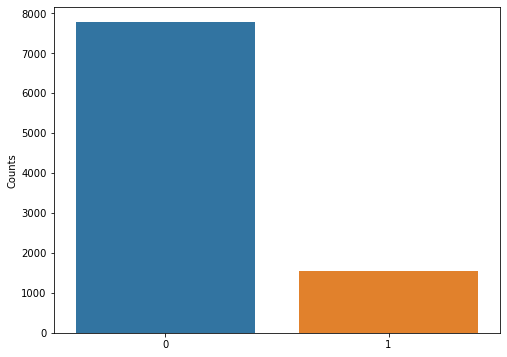

In [67]:

#Random Undersampling and Oversampling
print(y_train.value_counts(normalize=False),'\n')

plt.figure(figsize=(8,6))
sns.countplot(y_train.values)
plt.ylabel('Counts')



0    83.472938
1    16.527062
Name: NEXT_INSPECTION_GRADE_C_OR_BELOW, dtype: float64 



Text(0, 0.5, 'Number of Custormers')

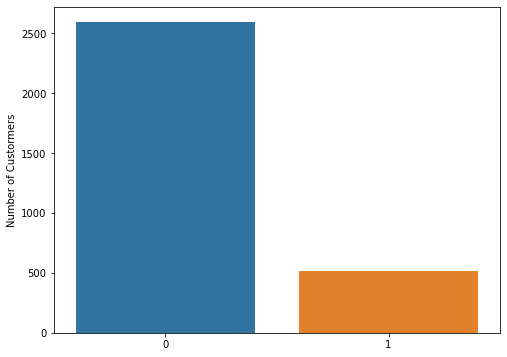

In [68]:

print( y_val.value_counts(normalize=True)*100,'\n')

plt.figure(figsize=(8,6))
sns.countplot(y_val.values)
plt.ylabel('Number of Custormers')


In [69]:


# With data been highly imbalanced, I will apply undersampling and oversampling on next inspection for the training data and also use an apropriate evaluation metrics which will be the roc_auc_score and precision recall. Combining both methods, will ensure there sufficnet data to train the models while reducing the class imbalnce problem.
# Majority class will be undersample and the minority class will be oversample to achieve 70% to 30% representation.

def random_under_over_sampling(X,y):
    
    ''' Undersamples majority class.
    
            Parameters:
        
                X(DataFrame): Python dataframe of custormers
            
                y(series): y variable (isFChurn)
            
              
    '''
    
    # define undersample strategy
    over = SMOTE(sampling_strategy=0.30)
    under = RandomUnderSampler(sampling_strategy=0.65)
    
    # first performing oversampling to minority class
    X_over, y_over = over.fit_resample(X, y)
    
    # fit and apply the transform
    X_combined_sampling, y_combined_sampling = under.fit_resample(X_over, y_over)

    print(y_combined_sampling.value_counts(normalize=False),'\n')

    plt.figure(figsize=(8,6))
    sns.countplot(y_combined_sampling.values)
    print( y_combined_sampling.value_counts(normalize=True)*100,'\n')

    plt.ylabel('Number of Custormers')
    
    return X_combined_sampling, y_combined_sampling
    

In [70]:

X_train.columns


Index(['CURRENT_DEMERITS', 'EMPLOYEE_COUNT', 'MEDIAN_EMPLOYEE_AGE',
       'MEDIAN_EMPLOYEE_TENURE', 'INSPECTION_TYPE', 'INSPECTION_DEMERITS',
       'FIRST_VIOLATION_TYPE', 'SECOND_VIOLATION_TYPE', 'THIRD_VIOLATION_TYPE',
       'NUMBER_OF_VIOLATIONS', 'LATITUDE', 'LONGITUDE', 'INSPECTION_TIME_HOUR',
       'INSPECTION_TIME_DAY', 'INSPECTION_TIME_MONTH', 'INSPECTION_TIME_YEAR',
       'RECORD_UPDATED_HOUR', 'RECORD_UPDATED_DAY', 'RECORD_UPDATED_MONTH',
       'RECORD_UPDATED_YEAR'],
      dtype='object')

In [71]:
X_train.isnull().sum()


CURRENT_DEMERITS          0
EMPLOYEE_COUNT            0
MEDIAN_EMPLOYEE_AGE       0
MEDIAN_EMPLOYEE_TENURE    0
INSPECTION_TYPE           0
INSPECTION_DEMERITS       0
FIRST_VIOLATION_TYPE      0
SECOND_VIOLATION_TYPE     0
THIRD_VIOLATION_TYPE      0
NUMBER_OF_VIOLATIONS      0
LATITUDE                  0
LONGITUDE                 0
INSPECTION_TIME_HOUR      0
INSPECTION_TIME_DAY       0
INSPECTION_TIME_MONTH     0
INSPECTION_TIME_YEAR      0
RECORD_UPDATED_HOUR       0
RECORD_UPDATED_DAY        0
RECORD_UPDATED_MONTH      0
RECORD_UPDATED_YEAR       0
dtype: int64

0    3586
1    2331
Name: NEXT_INSPECTION_GRADE_C_OR_BELOW, dtype: int64 

0    60.605036
1    39.394964
Name: NEXT_INSPECTION_GRADE_C_OR_BELOW, dtype: float64 



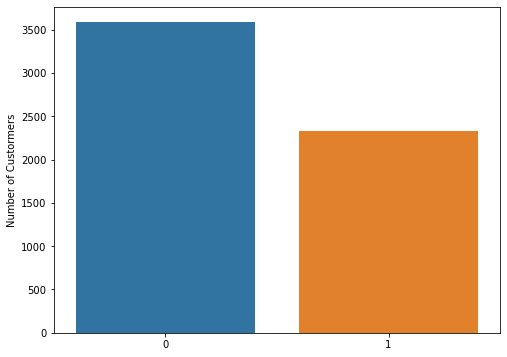

In [72]:

X_train,y_train=random_under_over_sampling(X_train,y_train)


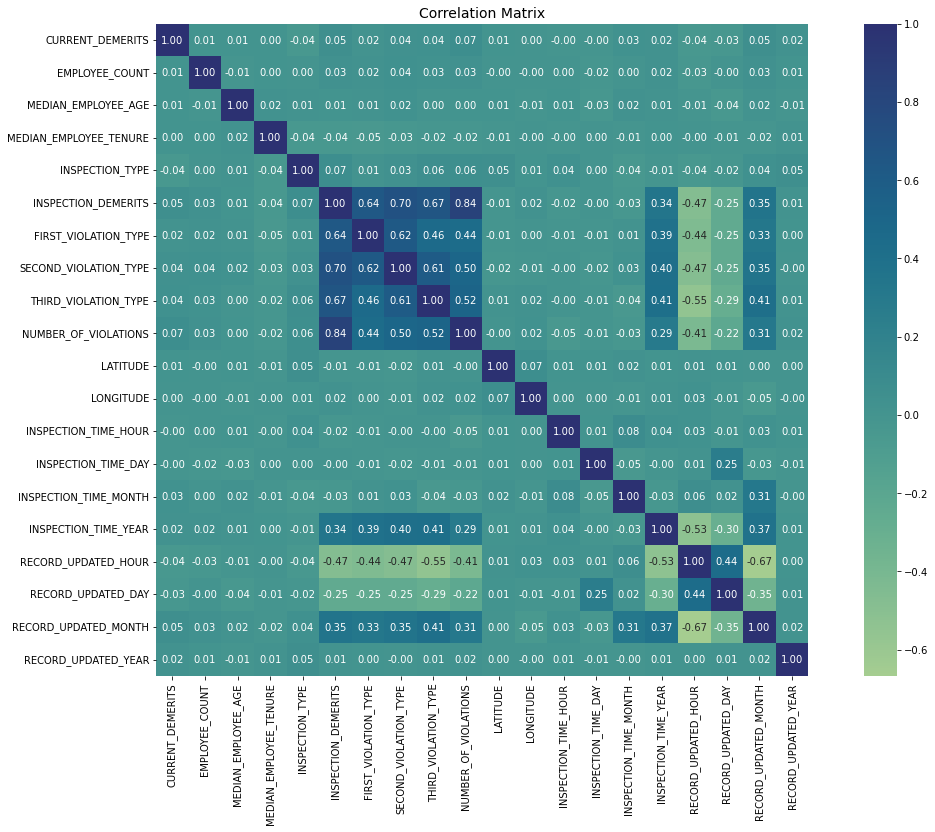

In [73]:

#Correlation plots to understand how the variables are related

fig, ax = plt.subplots(figsize=(20,12))         
corr = X_train.corr()
sns.heatmap(corr, annot=True, fmt='.2f', square=True, cmap = 'crest')
ax.set_title("Correlation Matrix", fontsize=14)
plt.show()


In [74]:

# Modelling
# I will create four models , Logistic Regression, Random Forest, XGBoost and CatBoost.
# Logistic Regression because it is very simple and makes it easy to understand how different variables explains inspection grade.
# Random forest combines different decision trees with the main purpose of minimizing variance on test set. For prediction we use the majority carry the vote approach to assign final labels.
# XGBoost as another ensemble model is very good at dealing with imbalance class problems. The sequential training process helps the algorithm to learn both balanced and imbalanced classes.
# Hyperparamter tuning will be done for all models and the best model chosen for testing
# I will mainly use roc_auc_score and recall precision to evaluate my models since I am dealing with class imbalanced problem. I will however, evaluate the models in terms of other metrics; Accuracy, and F1 score.
# Model Helper Functions

def candidate_models():
    
    ''' Creates a list of models to be trained
    
       Returns
       
           basedModels: A list of candidate models
    '''
    
    basedModels = []
    
    basedModels.append(('Logistic Regression'  , LogisticRegression()))
    
    basedModels.append(('Random Forest'   , RandomForestClassifier()))
    
    basedModels.append(('XGBoost'  , XGBClassifier()))
    
    return basedModels




# Evaluation metric definition
def evaluate_candidates(X_train, y_train,models):
    
    ''' Evaluates candidate models through 10 fold cross-validation
    
        Parameters:
        
            X_train: A python dataframe for train features
            
            y_train: A python dataframe for training features
            
            models: A list of candidate models 
    
    '''
    # Test options and evaluation metric
    num_folds = 10
    
    accuracy = []
    precision= []
    recall= []
    f1= []
    roc= []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=num_folds,random_state=None)
        
        cv_accuracy = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
        
        cv_precision = cross_val_score(model, X_train, y_train, cv=kfold, scoring='precision')
        
        cv_recall = cross_val_score(model, X_train, y_train, cv=kfold, scoring='recall')
        
        cv_f1 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
        
        cv_roc = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
       
        
        accuracy.append(cv_accuracy)
        
        precision.append(cv_precision)
        
        recall.append(cv_recall)
        
        f1.append(cv_f1)
        
        roc.append(cv_roc)
        
        names.append(name)
        
        msg = "%s: %f (%f) %f (%f) %f (%f) %f (%f) %f (%f)" % (name, cv_accuracy.mean(),                                                             cv_accuracy.std(),cv_precision.mean(),cv_precision.std(),
                                                       cv_recall.mean(),cv_recall.std(),cv_f1.mean(),cv_f1.std(),cv_roc.mean(),cv_roc.std())  
    return names, accuracy, precision, recall ,f1,roc


# Present results as a dataframe
def candidate_results(names,acc,pre,rec,f1,roc):
    
    '''Creates dataframe for cross validation results
    
        Paramters:
        
            names (string): list of model names
            
            acc (list) : list accuracy of models
            
            pre (list) : precision of models
            
            f1 (list) : f1 score of models
            
            roc (list) : roc_auc score of models
            
        Returns:
        
            scoreDataFrame (DataFrame): A dataframe of average evaluation metrics. 
        
    '''
    
    
    def floating_decimals(f_val, dec=3):
        prc = "{:."+str(dec)+"f}" 

        return float(prc.format(f_val))

    accuracy = []
    
    precision=[]
    
    recall=[]
    
    f_score=[]
    
    roc_score=[]
    
    for a in acc:
        
        accuracy.append(floating_decimals(a.mean(),4))
        
    for p in pre:
        
        precision.append(floating_decimals(p.mean(),4))
        
    for r in rec:
        
        recall.append(floating_decimals(r.mean(),4))
        
    for f in f1:
        
        f_score.append(floating_decimals(f.mean(),4))
        
    for l in roc:
        
         roc_score.append(floating_decimals(l.mean(),4))
    
    a = {'Model':names, 'Accuracy':accuracy,'Precision':precision,'Recall':recall,'F1':f_score,'ROC': roc_score}
    
    scoreDataFrame = pd.DataFrame.from_dict(a, orient='index')
    
    scoreDataFrame = scoreDataFrame.transpose()  
    
    return scoreDataFrame



def plot_roc_validation(model_names,roc_scores):
    
    ''' Plots boxplot of cross validation roc scores for candidate models
    
        Parameters:
        
            model_names: A list of model names
            
            roc_scores: Array of roc_auc score for all models
    
    '''
    
    plt.subplots(figsize=(12,8)) 
    sns.boxplot(data=roc_scores)
    plt.xlabel('Models')
    plt.ylabel('Roc Score')
    plt.xticks(range(0, len(model_names)), model_names)
    
    
    
def hyperparamter_tuning(model,params,X_train,y_train):
    
    ''' Conducts Hyperparamter tuning to get best version of a model
    
            Parameters:
            
                model: model object
                
                params: hyperparamters to be tuned
                
                X_train: dataframe of train data
                
                y_train: series of dependent variable (isChurn)
                
            Returns:
             
                grid_search.best_estimator_: Best model from gridsearch
                
                grid_search.best_score_: Score from best model
                
    '''
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
    
    grid_search = GridSearchCV(estimator=model,param_grid=params,verbose=1, cv=cv,n_jobs=-1,scoring='roc_auc',error_score=0)
    
    grid_search.fit(X_train, y_train)
    
    return grid_search.best_estimator_, grid_search.best_score_


def plot_test_perf(y_test, y_pred, y_pred_prob):
    
    ''' Plots ROC and Precsion Recall curve
    
            Parameters:
                
                y_test: 1d array of y test values
                
                y_pred: 1d array of predicted test values
                
                y_pred_prob: 1d array of predicted probabilities test values
    
    '''
   
    test_fpr, test_tpr, _ = roc_curve(y_test, y_pred_prob)
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
   
    # ROC Curve"
    fig = plt.figure(1, figsize=(10,5))
    
    plt.subplot(1, 2, 1)
    
    plt.plot(test_fpr, test_tpr, label="ROC (area = %0.4f)" % roc_auc_score(y_test, y_pred), color = "red",lw=2)
    
    plt.plot([0, 1], [0, 1])
    
    plt.legend(loc="lower right")
    
    plt.xlabel("False Positive Rate")
    
    plt.ylabel("True Positive Rate")
    
    plt.title("ROC Curve")
   
    # Precision Recall Curve
    plt.subplot(1, 2, 2)
    
    plt.plot(recall, precision, marker='.', color="red", lw=2)
    
    plt.xlabel('Recall')
    
    plt.ylabel('Precision')
    
    plt.title("Precision Recall Curve")
  
    plt.tight_layout()
    
    plt.show()


def plot_confusion_test(y_val, y_pred,y_names):
    
    '''Plots Confusion Matrix for model
    
        Parameters:
        
            y_test: 1d array of y test values
                
            y_pred: 1d array of predicted test values
            
            y_names: list of dependent variable (levels) ['active','Churn']
    
    '''
    
    cm = confusion_matrix(y_val, y_pred)
  
    # Confusion Matrix\n",
    fig=plt.figure(figsize=(10,10))
    
    ax =  fig.add_subplot(1,1,1, adjustable='box', aspect=1)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    
    plt.colorbar()
    
    tick_marks = np.arange(len(y_names))
    
    plt.xticks(tick_marks,y_names, rotation=45)
    
    plt.yticks(tick_marks, y_names)

    thresh = cm.max() /2
    
    for i in range (cm.shape[0]):
        
        for j in range (cm.shape[1]):
            
            plt.text(j, i, format(cm[i, j], 'd'),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
            
    plt.ylabel('True label')
    
    plt.xlabel('Predicted label')
    
    np.set_printoptions(precision=2)
    plt.show()
        
        
def feature_importance(model,train):
    
    ''' Calculates and Plots feature Importance for model on training data
            
            Parameters:
            
                model: model object
                
                train: dataframe of training data
    
    '''
    
    sorted_idx = model.feature_importances_.argsort()
    
    plt.figure(figsize=(14,10))
    
    plt.barh(train.columns[sorted_idx], model.feature_importances_[sorted_idx])
    
    plt.title('Feature Importance for best model')
    
    plt.xlabel("Feature Importance")
    
  

In [75]:
  
# Training Models
# In this section, I train my three candidate models, Logistic Regression, Random Forest and XGBoost. The models were evaluated using 10-fold cross validation.
# I will call the evaluate_candidates function from the Helper functions above to train the models

X_train.head()


,CURRENT_DEMERITS,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_TYPE,INSPECTION_DEMERITS,FIRST_VIOLATION_TYPE,SECOND_VIOLATION_TYPE,THIRD_VIOLATION_TYPE,NUMBER_OF_VIOLATIONS,LATITUDE,LONGITUDE,INSPECTION_TIME_HOUR,INSPECTION_TIME_DAY,INSPECTION_TIME_MONTH,INSPECTION_TIME_YEAR,RECORD_UPDATED_HOUR,RECORD_UPDATED_DAY,RECORD_UPDATED_MONTH,RECORD_UPDATED_YEAR
0,-0.459638,-0.793383,-0.669405,0.071751,1,-0.395044,1,1,1,-0.582312,0.235481,0.095778,-1.658576,0.843933,-0.378010,-0.112990,0.674151,0.338541,-0.502508,-0.021987
1,-1.271039,-1.369576,-0.175698,1.172064,1,-0.540166,1,0,1,-0.981793,0.004899,0.095768,-0.597551,-0.888639,1.179574,-0.864558,0.674151,0.338541,-0.502508,-0.021987
2,-0.459638,0.359002,-1.412225,1.236912,1,0.620812,2,2,1,-0.182832,0.225406,0.091445,0.463474,-1.235154,-1.001043,-0.112990,0.674151,0.338541,-0.502508,-0.021987
3,-1.271039,0.819956,0.829646,-0.131189,1,-0.395044,2,1,0,-0.582312,-0.120116,0.084446,0.109799,-0.888639,0.245024,-0.488774,0.674151,0.338541,-0.502508,-0.021987
4,-0.459638,-1.369576,-1.125118,-0.427465,1,-1.410900,0,0,0,-0.981793,-0.018591,0.094227,-0.243876,0.728429,-1.312560,-0.864558,0.674151,0.338541,-0.502508,-0.021987


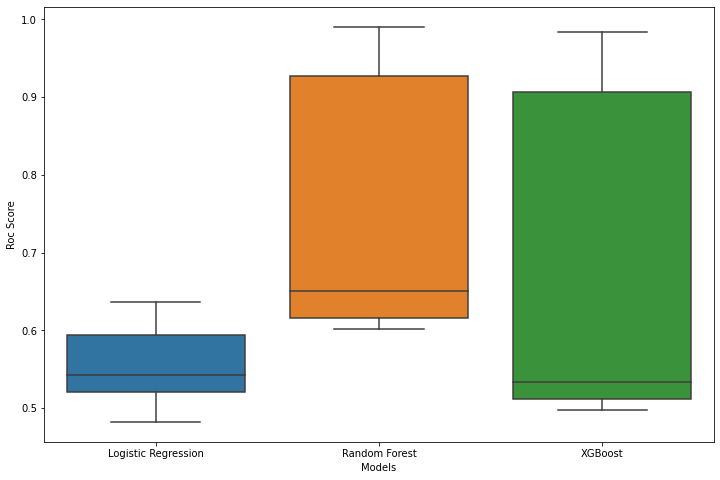

In [76]:

models= candidate_models()
names,acc,pre,rec,f1,roc = evaluate_candidates(X_train,y_train,models)
evaluatiod_df = candidate_results(names,acc,pre,rec,f1,roc)
evaluatiod_df

#The distribution of roc_auc scores across the three models for cross validation is shown below. Random Forest slightly outperforms the other two models in terms of the average roc_auc score.

plot_roc_validation(names,roc)

#The distribution of roc_auc scores across the three models for cross validation is shown below. From the median value, the XGBOOST outperforms the other two models.However the models were training at their default hyperparameters. In the next section, I will tune each model using the gridsearch approach.



In [77]:

#Logistic Regression
params = {'penalty':['l2','l1'],'C': [0.01, 0.1, 1, 10, 100]}
model=LogisticRegression()
LR_best,LR_score=hyperparamter_tuning(model,params,X_train,y_train)
print('Best roc_auc score from Logistic Regression: {}'.format(LR_score))

# Fitting 10 folds for each of 10 candidates, totalling 100 fits
# Best roc_auc score from Logistic Regression: 0.5622642124648894

#Random Forest
params = {
    'n_estimators':[100,200,300,500],
    'max_depth': range(1, 100, 10),
    'min_samples_leaf': [0,1,2,3,4]}
model=RandomForestClassifier()
RF_best,RF_score=hyperparamter_tuning(model,params,X_train,y_train)
print('Best roc_auc score from Random Forest Classifier: {}'.format(RF_score))


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best roc_auc score from Logistic Regression: 0.556770437146062
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Best roc_auc score from Random Forest Classifier: 0.7535567200761818


In [78]:

#XGBoost
params = {
    'n_estimators': [100, 250, 700],
    'learning_rate': [0.05,0.1,0.4],
    'booster': ['gbtree', 'gblinear'],
    

}
model=XGBClassifier()
XGB_best,XGB_score=hyperparamter_tuning(model,params,X_train,y_train)
print('Best roc_auc score from XGBoost: {}'.format(XGB_score))



Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best roc_auc score from XGBoost: 0.6863650011644096


In [79]:
# #make prediction
# from sklearn.metrics import confusion_matrix
# plot_confusion_test(y_val, yhat1,['Positive','Negative'])


# from sklearn import metrics
# fpr, tpr, thresholds = metrics.roc_curve(y_val, yhat1, pos_label=0)
# metrics.auc(fpr, tpr)


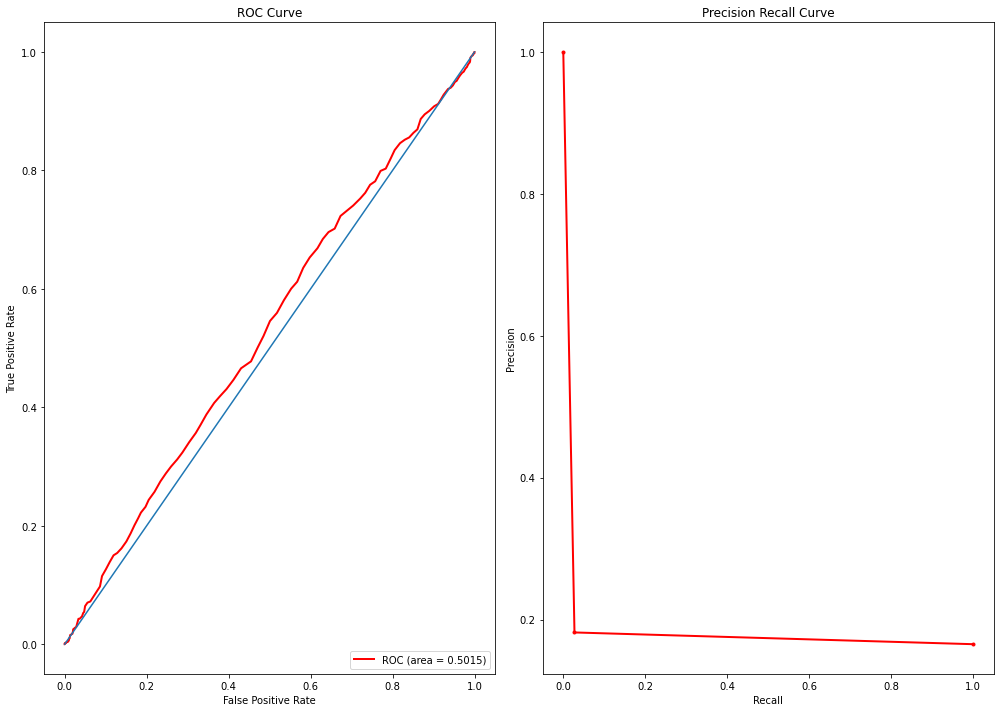

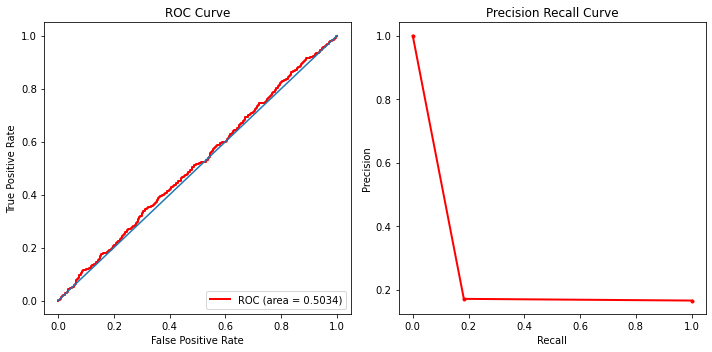

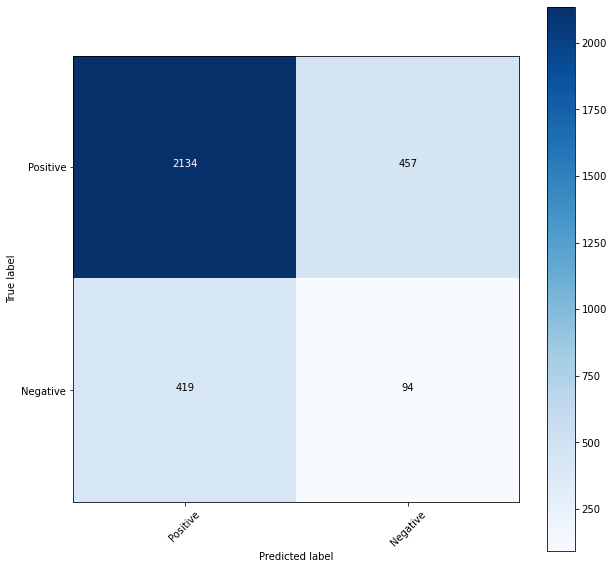

In [80]:


#Feature Importance for Best Model (Random Forest)

feature_importance(RF_best,X_train)

# From the variable importance plot above, Median_Employee_tenure is the most important variable in prediction followed by The locations(Latitude,Longitude). The Employee Median Age also important so are Inspection Time and Employee Count.

# Model Evaluation on Test Data

# Comparing the besst versions of each model, the XGBoost has the best roc value so I will choose this as my final model for grading restaurant inspections.

# ROC and Precision Recall curves

# The ROC curve is obtained by plotting the true positive rate (TPR) against the false positive rate (FPR). It shows the trade off between true positive rate and false postive rate. Since Restaurants that are graded c or above in the data is rare, the ROC curve is approapriate for evlauting the models.

# The precision-recall curve also shows the relationship between recall and precision. That is comparing the proportion of actual Grade C or above predicted to the proportion of correctly predicted class at different probability thresholds/cutoffs.

#get preictions
y_pred=RF_best.predict(X_val)

#get predicted probabilities
y_pred_proba=RF_best.predict_proba(X_val)[:,1]

#get roc recall precision curve
plot_test_perf(y_val,y_pred, y_pred_proba)

y_pred=XGB_best.predict(X_val)

#get predicted probabilities
y_pred_proba=XGB_best.predict_proba(X_val)[:,1]

#get roc recall precision curve
plot_test_perf(y_val,y_pred, y_pred_proba)

#Confusion Matrix
plot_confusion_test(y_val, y_pred,['Positive','Negative'])


In [81]:

#Test Data Cleaning And Final prections
file_path = os.getcwd()+"/TEST_SET_2022.csv"#'/content/drive/MyDrive/final_submission/TEST_SET_2022.csv'
test_df = pd.read_csv(file_path)


In [82]:

test_df.rename(columns={'current_grade':'CURRENT_GRADE','RESTAURANT_CATAGORY':'RESTAURANT_CATEGORY'}, inplace=True)
tt=test_df.copy()
test_df.nunique()


RESTAURANT_SERIAL_NUMBER    7505
RESTAURANT_PERMIT_NUMBER    5437
RESTAURANT_NAME             5257
RESTAURANT_LOCATION         3532
RESTAURANT_CATEGORY           29
ADDRESS                     3441
CITY                          17
STATE                          1
ZIP                         1974
CURRENT_DEMERITS              48
CURRENT_GRADE                  8
INSPECTION_TIME             7190
INSPECTION_TYPE                4
INSPECTION_DEMERITS           65
VIOLATIONS_RAW              6176
RECORD_UPDATED              2372
LAT_LONG_RAW                3426
FIRST_VIOLATION               69
SECOND_VIOLATION              72
THIRD_VIOLATION               75
FIRST_VIOLATION_TYPE           5
SECOND_VIOLATION_TYPE          5
THIRD_VIOLATION_TYPE           5
NUMBER_OF_VIOLATIONS          24
EMPLOYEE_COUNT              6641
MEDIAN_EMPLOYEE_AGE         7358
MEDIAN_EMPLOYEE_TENURE      7505
dtype: int64

In [83]:

test_df.isnull().sum()


RESTAURANT_SERIAL_NUMBER    0
RESTAURANT_PERMIT_NUMBER    0
RESTAURANT_NAME             0
RESTAURANT_LOCATION         1
RESTAURANT_CATEGORY         0
ADDRESS                     2
CITY                        3
STATE                       0
ZIP                         2
CURRENT_DEMERITS            0
CURRENT_GRADE               2
INSPECTION_TIME             3
INSPECTION_TYPE             0
INSPECTION_DEMERITS         0
VIOLATIONS_RAW              0
RECORD_UPDATED              0
LAT_LONG_RAW                0
FIRST_VIOLATION             0
SECOND_VIOLATION            0
THIRD_VIOLATION             0
FIRST_VIOLATION_TYPE        0
SECOND_VIOLATION_TYPE       0
THIRD_VIOLATION_TYPE        0
NUMBER_OF_VIOLATIONS        0
EMPLOYEE_COUNT              0
MEDIAN_EMPLOYEE_AGE         0
MEDIAN_EMPLOYEE_TENURE      0
dtype: int64

In [84]:

test_df = split_lat_long(test_df,'LAT_LONG_RAW',['LATITUDE','LONGITUDE'])   

test_df.drop('LAT_LONG_RAW',axis=1, inplace=True)

test_df['LATITUDE'] = test_df['LATITUDE'].apply(to_floats)
test_df['LONGITUDE'] = test_df['LONGITUDE'].apply(to_floats)



In [85]:

test_df['INSPECTION_TIME_HOUR'] = test_df['INSPECTION_TIME'].apply(print_time).dt.hour
test_df['INSPECTION_TIME_DAY'] = test_df['INSPECTION_TIME'].apply(print_time).dt.day
test_df['INSPECTION_TIME_MONTH'] = test_df['INSPECTION_TIME'].apply(print_time).dt.month
test_df['INSPECTION_TIME_YEAR'] = test_df['INSPECTION_TIME'].apply(print_time).dt.year
test_df['RECORD_UPDATED_HOUR'] = test_df['RECORD_UPDATED'].apply(print_time).dt.hour
test_df['RECORD_UPDATED_DAY'] = test_df['RECORD_UPDATED'].apply(print_time).dt.day
test_df['RECORD_UPDATED_MONTH'] = test_df['RECORD_UPDATED'].apply(print_time).dt.month
test_df['RECORD_UPDATED_YEAR'] = test_df['RECORD_UPDATED'].apply(print_time).dt.year   

test_df=test_df.apply(lambda row: replace_violation_type(row, 'FIRST_VIOLATION'), axis=1)
test_df=test_df.apply(lambda row: replace_violation_type(row, 'SECOND_VIOLATION'), axis=1)
test_df=test_df.apply(lambda row: replace_violation_type(row, 'THIRD_VIOLATION'), axis=1)

test_df['THIRD_VIOLATION_TYPE']=test_df['THIRD_VIOLATION_TYPE'].replace('Imminent Health Hazard','Critical')
## Current grade creation
test_df['CURRENT_GRADE']=test_df['CURRENT_DEMERITS'].apply(create_current_grade)

ind=test_df[~test_df['INSPECTION_TYPE'].isin(['Routine Inspection','Re-inspection'])].index
test_df.loc[ind,'INSPECTION_TYPE']=np.NaN
test_df['INSPECTION_TYPE']=test_df['INSPECTION_TYPE'].fillna(X_train_copy['INSPECTION_TYPE'].mode().iloc[0])


test_df[upt1]=test_df[upt1].fillna(X_train.mean().iloc[0])



test_df.drop(columns=['RESTAURANT_NAME','RESTAURANT_CATEGORY',
                'FIRST_VIOLATION', 'SECOND_VIOLATION','CURRENT_GRADE',
       'THIRD_VIOLATION','INSPECTION_TIME','ZIP','STATE','CITY','ADDRESS','RESTAURANT_LOCATION',\
         'RESTAURANT_SERIAL_NUMBER','RESTAURANT_PERMIT_NUMBER','VIOLATIONS_RAW','RECORD_UPDATED'],inplace=True)

test_df=OrdEncode_categories(test_df)
test_df=OnehotEncode_categories(test_df,Norminal)

In [86]:

_,test_df=numerical_feature_transform(X_train,test_df,num_col)
test_df.isnull().sum()



CURRENT_DEMERITS          0
INSPECTION_TYPE           0
INSPECTION_DEMERITS       0
FIRST_VIOLATION_TYPE      0
SECOND_VIOLATION_TYPE     0
THIRD_VIOLATION_TYPE      0
NUMBER_OF_VIOLATIONS      0
EMPLOYEE_COUNT            0
MEDIAN_EMPLOYEE_AGE       0
MEDIAN_EMPLOYEE_TENURE    0
LATITUDE                  0
LONGITUDE                 0
INSPECTION_TIME_HOUR      0
INSPECTION_TIME_DAY       0
INSPECTION_TIME_MONTH     0
INSPECTION_TIME_YEAR      0
RECORD_UPDATED_HOUR       0
RECORD_UPDATED_DAY        0
RECORD_UPDATED_MONTH      0
RECORD_UPDATED_YEAR       0
dtype: int64

In [89]:
X_train.columns == test_df.columns

array([ True, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [92]:
test_df = test_df.reindex(columns=X_train.columns)

In [94]:

final_pred2=RF_best.predict(test_df)
probas = RF_best.predict_proba(test_df)[:,1]
final_pred3=XGB_best.predict(test_df)
 
preditions= pd.DataFrame({'RESTAURANT_SERIAL_NUMBER': tt.RESTAURANT_SERIAL_NUMBER,'CLASSIFIER_PROBABILITY':probas, 'CLASSIFIER_PREDICTION': final_pred3})
print(preditions)

preditions[preditions['CLASSIFIER_PREDICTION']==1].shape

preditions[preditions['CLASSIFIER_PREDICTION']==0].shape

preditions.to_csv('predictions_Amuzu_Lionel.csv', index=False)
 


 

     RESTAURANT_SERIAL_NUMBER  CLASSIFIER_PROBABILITY  CLASSIFIER_PREDICTION
0                   DA1050454                0.486667                      0
1                   DA0986444                0.446667                      0
2                   DA1284914                0.490000                      0
3                   DA1281903                0.443333                      0
4                   DA1004708                0.490000                      1
...                       ...                     ...                    ...
7500                DA0922689                0.430000                      0
7501                DA1031095                0.490000                      1
7502                DA0633450                0.493333                      0
7503                DA0998980                0.490000                      1
7504                DA0831126                0.490000                      1

[7505 rows x 3 columns]


"Clearly, the results have not met my expectations, primarily due to the model's overfitting. The discrepancy between the training and evaluation errors suggests that the model is not generalizing well to unseen data.

Moving forward, I plan to delve deeper into feature engineering as I suspect that the available features may not be sufficient for accurate predictions. For example, the current grade and its associated demerits appear to be highly correlated, effectively representing similar information and thus not contributing as distinct predictive features. During the training process, I eliminated one of these correlated features to mitigate redundancy.

To uncover potential insights, I will further investigate the 'violation' raw feature.

Additionally, I will allocate more time to hyperparameter tuning. By adjusting these hyperparameters, I hope to improve the model's performance and mitigate the overfitting issue.

In conclusion, further refinement and deeper analysis of the features and model parameters are necessary to achieve a more accurate and reliable model."

# THANK YOU ALL Looking forward to working with you.